# Running cellpose 2.0 in colab with a GPU

<font size = 4>Cellpose 2.0 now allows you to train your own models in the GUI!

This notebook allows you to load this **custom model** and run the model on your images with a GPU.

In this notebook, you can also **train** a custom model using your labels (`_seg.npy`) files, or other labels as `_masks.tif` files. If you already have a trained model, skip this part of the notebook.

For more details on cellpose 2.0 check out the [paper](https://www.biorxiv.org/content/10.1101/2022.04.01.486764v1) or the [talk](https://www.youtube.com/watch?v=3ydtAhfq6H0).

Mount your google drive to access all your image files, segmentations, and custom models. This also ensures that any models you train are saved to your google drive. If you'd like to try out the notebook without your own files, please download the sample images from tissuenet (optional step in Setup below).

This notebook was inspired by the Zero-Cost Deep-Learning to Enhance Microscopy project (https://github.com/HenriquesLab/DeepLearning_Collab/wiki). Jointly developed by the Jacquemet (link to https://cellmig.org/) and Henriques (https://henriqueslab.github.io/) laboratories. Please check out their great work!

# Setup

We will first install cellpose 2.0, check the GPU is working, and mount google drive to get your models and images.

In [ ]:
!pip install "opencv-python-headless<4.3"
!pip install cellpose

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 15.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstalled opencv-python-headless-4.8.1.78
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.3.1 requires opencv-python-headless>=4.1.1, but you have opencv-python-headless 3.4.18.65 which is incompatible.
qudida 0.0.4 requires opencv-python-headless>=4.0.1, but you have opencv-python-headless 3.4.18.65 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.5/173.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 39.5 MB/s eta 0:00:00


In [ ]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
/bin/bash: line 1: nvidia-smi: command not found
>>> GPU activated? NO


In [ ]:

#@markdown ###Run this cell to connect your Google Drive to Colab

#@markdown * Click on the URL.

#@markdown * Sign in your Google Account.

#@markdown * Copy the authorization code.

#@markdown * Enter the authorization code.

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive".

#mounts user's Google Drive to Google Colab.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In the

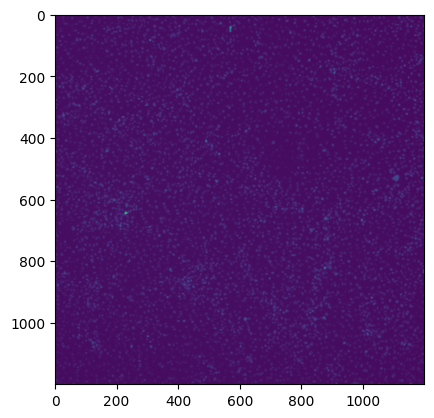

In [ ]:
dir='/content/gdrive/MyDrive/test_image/'
nom='S3_concatenate_Nuclei-1.tif'
img=io.imread(dir+nom)
plt.figure()
plt.imshow(img)

In [ ]:
# set parameters
diameter=12
model_path='nuclei'
chan='Grayscale'
chan2='none'
flow_threshold=0
cellprob_threshold=-6


In [42]:
files = [file for file in os.listdir(dir) if file.endswith('1.tif')]
files = [os.path.join(dir, f) for f in files]
print(files)

['/content/gdrive/MyDrive/test_image/S3_concatenate_Nuclei-1.tif']


In [43]:
# gets image files in dir (ignoring image files ending in _masks)

images = [io.imread(f) for f in files]

# declare model
model = models.CellposeModel(gpu=True,
                             pretrained_model=model_path)

# use model diameter if user diameter is 0
diameter = model.diam_labels if diameter==0 else diameter

# run model on test images
masks, flows, styles = model.eval(images,
                                  channels=[chan, chan2],
                                  diameter=diameter,
                                  flow_threshold=flow_threshold,
                                  cellprob_threshold=cellprob_threshold
                                  )

In [44]:
from cellpose import io

io.masks_flows_to_seg(images,
                      masks,
                      flows,
                      diameter*np.ones(len(masks)),
                      files,
                      [chan, chan2])

In [45]:
io.save_masks(images,
              masks,
              flows,
              files,
              channels=[chan, chan2],
              png=True, # save masks as PNGs and save example image
              tif=True, # save masks as TIFFs
              save_txt=True, # save txt outlines for ImageJ
              save_flows=True, # save flows as TIFFs
              save_outlines=True, # save outlines as TIFFs
              )


In [46]:

plt.figure(figsize=(12,4), dpi=300)
plt.imshow(io.imread(os.path.splitext(f)[0] + '_outlines.png'))
plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

(-0.5, 1199.5, 1199.5, -0.5)

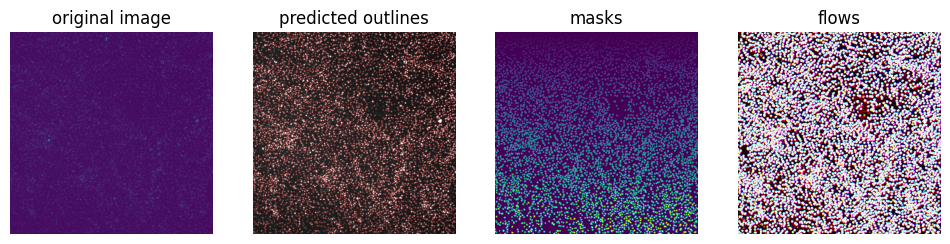

In [ ]:
from cellpose import plot
masks=io.imread(os.path.splitext(f)[0] + '_cp_masks.tif')
flows=io.imread(os.path.splitext(f)[0] + '_flows.tif')
outlines=io.imread(os.path.splitext(f)[0] + '_outlines.png')
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(1,4,1)
ax.imshow(img)
ax.set_title('original image')
ax.axis('off')
ax = fig.add_subplot(1,4,2)
ax.imshow(outlines)
ax.set_title('predicted outlines')
ax.axis('off')
ax = fig.add_subplot(1,4,3)
ax.imshow(masks)
ax.set_title('masks')
ax.axis('off')
ax = fig.add_subplot(1,4,4)
ax.imshow(flows)
ax.set_title('flows')
ax.axis('off')